In [1]:
#imports
import pickle
import numpy
import torch
from torch.utils import data # trabalhar com dados iterados
import random
from transformers import BertModel, BertTokenizer
import pandas as pd
import jsonlines
from transformers import AutoTokenizer
import sklearn
from sklearn import svm
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import AutoModelForSequenceClassification
from transformers import get_scheduler
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from torch import nn # neural network in pytorch
import torch.nn.functional as F
import timeit  # calcular metrica de tempo
import io
from sklearn.datasets import load_svmlight_file, load_svmlight_files

SEED=42
random.seed(SEED); torch.manual_seed(SEED); numpy.random.seed(seed=SEED) # reproducibily soluction



/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#hyper-parametros
batch_size=32
lr=0.0001
max_epochs=5
limit_patient=5


#datasets = ['acm', 'reut', '20ng', 'webkb', 'aisopos_ntua_2L',  'vader_movie_2L', 'vader_nyt_2L', 'books', 'dblp'] # 10 folds
datasets = ['agnews','sogou', 'yelp_2015', 'imdb_reviews' ] # 5 folds
datasets= [ 'debate_2L', 'english_dailabor_2L', 'nikolaos_ted_2L', 'pang_movie_2L' ]# webkb
datasets = ['aisopos_ntua_2L',  'vader_movie_2L', 'vader_nyt_2L','sentistrength_bbc_2L', 'sentistrength_digg_2L', 'yelp_review_2L']
datasets=['webkb']
datasets=['reut']

index_folds = [0,1,2,3,4,5,6,7,8,9]
#index_folds = [0]

In [3]:
# codigo em uma unica celula para executar folds
for dataset in datasets:
    for index_fold in index_folds:
        nome_experimento= f'{dataset}_tfidf_reduction_fold{index_fold}' 
        ini = timeit.default_timer()
        print(nome_experimento)

        # carregar dados
        ids = pickle.load( open(f'dataset/{dataset}/splits/split_10_with_val.pkl', 'rb') )
        

        # X = []; labels = []
        # index_doc = 0
        
        # with io.open(f'../input/datasets-lbd/dataset/{dataset}/texts.txt', newline='\n', errors='ignore') as read:
        #     for row in read:
        #         X.append( row.strip() )                    
                
        # X = [preprocessor(x) for x in X]

        
        # for line in open(f'../input/datasets-lbd/dataset/{dataset}/score.txt'):          
        #   labels.append( int(line.strip()) )   
        
        # for index in range(len(labels)): # cannot use negative label
        #     if labels[index] == -1: labels[index] = 0
        
        

        # #X = X[0:200]
        # #labels = labels[0:200]
        # X = pd.DataFrame(X, columns=['text'])
        # X['label'] = labels

        # x_train = X.iloc[  ids['train_idxs'][index_fold] ] # seleciona a partir de indices
        # x_val = X.iloc[  ids['val_idxs'][index_fold] ]
        # x_test = X.iloc[  ids['test_idxs'][index_fold] ]


        
        # if teste_rapido == True:
        #     x_train = x_train.sample(quantidade_amostra)
        #     x_val = x_val.sample(quantidade_amostra)
        #     x_test = x_test.sample(quantidade_amostra)

        
        x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test = load_svmlight_files([open(f'kaggle_tfidf/{dataset}_tfidf_train{index_fold}', 'rb'),
         open(f'kaggle_tfidf/{dataset}_tfidf_val{index_fold}', 'rb'), open(f'kaggle_tfidf/{dataset}_tfidf_test{index_fold}', 'rb')])

        num_labels = len(numpy.unique(y_train))
        print(f'num_labels {num_labels}')

        # carregar dataset no formato do torch
        class CustomDataset(torch.utils.data.Dataset):
            def __init__(self, encodings, labels):
                self.encodings = encodings
                self.labels = labels

            def __getitem__(self, idx):
                item =  {'vetor' : torch.tensor(self.encodings[idx,:].todense()).reshape(-1)  }                        
                item['label'] = torch.tensor(self.labels[idx])
                return item

            def __len__(self):
                return len(self.labels)
        
        # tfidf        
        # vectorizer = TfidfVectorizer()
        # x_train_tfidf = vectorizer.fit_transform(list(x_train['text']))
        # x_val_tfidf = vectorizer.transform(list(x_val['text']))
        # x_test_tfidf = vectorizer.transform(list(x_test['text']))
        
        
        train_dataset = CustomDataset(x_train_tfidf, y_train )
        val_dataset = CustomDataset(x_val_tfidf, y_val )
        test_dataset = CustomDataset(x_test_tfidf, y_test )

        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, worker_init_fn=SEED)
        eval_dataloader = DataLoader(val_dataset, batch_size=batch_size, worker_init_fn=SEED)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, worker_init_fn=SEED)
        
        # classe para reducao de dimensionalidade
        class Reduction(nn.Module):
          def __init__(self, tamanho_tfidf):
            super().__init__()                
            
            self.encoder = nn.Sequential(nn.Linear(tamanho_tfidf, tamanho_tfidf)) #encoder 
            self.softmax = nn.Sequential(  nn.Linear(tamanho_tfidf, num_labels), nn.Softmax(dim=1) )
                        

          def forward(self, X):
            encoder = self.encoder( X )
            y_pred = self.softmax(encoder)
            return encoder, y_pred #, y_pred

        # definino modelo
        model = Reduction(x_train_tfidf.shape[1])                
        loss =  nn.CrossEntropyLoss()          
        optimizer = AdamW(model.parameters(), lr=lr)


        num_training_steps = max_epochs * len(train_dataloader)
        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps
        )

        # Coloca para o processamento ser feito na GPU
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        model.to(device)

        ###
        # Treina o modelo
        progress_bar = tqdm(range(num_training_steps))
        loss_train = []; loss_eval = []; macro_f1_eval = []; micro_f1_eval = []; wei_f1_eval = []
        cont_patient=0; min_loss_eval =10000; max_macro_eval=-1        

        for epoch in range(max_epochs):
            print(f'Epoch: {epoch}')
            model.train()
            for batch in train_dataloader:                
                batch = {k: v.to(device) for k, v in batch.items()}                   
                _,  y_pred = model(batch['vetor'].float())
                l = loss(y_pred, batch["label"].to(torch.int64) )
                l.backward() 
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                progress_bar.update(1)       

            loss_train.append(l.item()) #loss treino
            
            # validação
            y_pred_list = []; y_true_list = []
            model.eval() # define para não atualizar pesos na validação
            for batch in eval_dataloader:
                batch = {k: v.to(device) for k, v in batch.items()}        

                with torch.no_grad(): # define para não atualizar pesos na validação                     
                    _,  y_pred = model(batch['vetor'].float())

                predictions = torch.argmax(y_pred, dim=-1)                   
                l = loss(y_pred,  batch["label"].to(torch.int64) )                                    
                y_pred_list.append(predictions.tolist()) 
                y_true_list.append( list(batch["label"].tolist()) )

            y_pred_batch = []; y_true_batch = []

            for y_batch in y_pred_list: # y_batchs
                for y_doc in y_batch:
                    y_pred_batch.append(y_doc)

            for y_batch in y_true_list: # y_batchs
                for y_doc in y_batch:
                    y_true_batch.append(y_doc)

            #armazena as metricas a partir das predicoes
            macro = sklearn.metrics.f1_score( y_true_batch , y_pred_batch, average='macro')
            micro = sklearn.metrics.f1_score( y_true_batch , y_pred_batch, average='micro')
            wei = sklearn.metrics.f1_score( y_true_batch , y_pred_batch, average='weighted')

            loss_eval_atual = l.item() #f1 loss
            loss_eval.append(loss_eval_atual); macro_f1_eval.append(macro); micro_f1_eval.append(micro); wei_f1_eval.append(wei)

            print(f'Loss: {loss_eval_atual}')
            print(f"Macro-f1: {macro}" )
            print(f"Micro-f1: {micro}" )
            print(f"Weighted-f1: {wei}" )

            # parar de treinar se não houver melhoria  na loss ou macro
            if loss_eval_atual < min_loss_eval or macro > max_macro_eval:
                cont_patient=0
                min_loss_eval = loss_eval_atual
                if macro > max_macro_eval:
                    max_macro_eval = macro
            else:
                cont_patient+=1

            if cont_patient >= limit_patient:
                break
        
        # carregar conjunto todo para transformar os textos
        train_dataset = CustomDataset(x_train_tfidf, y_train )
        val_dataset = CustomDataset(x_val_tfidf, y_val )
        test_dataset = CustomDataset(x_test_tfidf, y_test )
        
        train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size, worker_init_fn=SEED)
        eval_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, worker_init_fn=SEED)
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, worker_init_fn=SEED)
        
                
        escreve =  jsonlines.open(f'{nome_experimento}.json', 'w')
        model.eval()
        with torch.no_grad():
            index_doc=0
            for batch in train_dataloader:        
                batch = {k: v.to(device) for k, v in batch.items()}        
                x_encod,  y_pred = model( batch['vetor'].float() )

                outputs = x_encod.cpu().detach().numpy().tolist()
                for out in outputs:
                    doc = {'id' :  ids['train_idxs'][index_fold][index_doc], 'tfidf' : out, 'label' : int(y_train[index_doc])}
                    escreve.write(doc)
                    index_doc+=1  
            
            
            index_doc=0
            for batch in eval_dataloader:        
                batch = {k: v.to(device) for k, v in batch.items()}        
                #x_encod, y_pred0, y_pred1, y_pred = model( batch['vetor'].float() )
                x_encod,  y_pred = model( batch['vetor'].float() )

                outputs = x_encod.cpu().detach().numpy().tolist() 
                for out in outputs:
                    doc = {'id' :  ids['val_idxs'][index_fold][index_doc], 'tfidf' : out, 'label' : int(y_val[index_doc])}
                    #doc = {'id' : index_doc, 'tfidf' : out[0], 'label' : int(X['label'][index_doc])}
                    escreve.write(doc)
                    index_doc+=1 

            index_doc=0      
            y_pred_list = [];
            for batch in test_dataloader:        
                batch = {k: v.to(device) for k, v in batch.items()}        
                #x_encod, y_pred0, y_pred1, y_pred = model( batch['vetor'].float() )
                x_encod,  y_pred = model( batch['vetor'].float() )

                outputs = x_encod.cpu().detach().numpy().tolist()
                for out in outputs:
                    doc = {'id' :  ids['test_idxs'][index_fold][index_doc], 'tfidf' : out, 'label' : int(y_test[index_doc])}
                    #doc = {'id' : index_doc, 'tfidf' : out[0], 'label' : int(X['label'][index_doc])}
                    escreve.write(doc)
                    index_doc+=1 

                # predicao do teste por softmax
                predictions = torch.argmax(y_pred, dim=-1) 
                y_pred_list.append(predictions.tolist()) 
                #y_true_list.append( list(batch["label"].tolist()) )

            y_pred_batch = []; y_true_batch = []

            for y_batch in y_pred_list: # y_batchs
                for y_doc in y_batch:
                    y_pred_batch.append(y_doc)

            escreve_pred = jsonlines.open(f'{nome_experimento}_pred.json', 'w')
            doc = {'index_fold' : index_fold, 'y_pred' : y_pred_batch, 'Macro-f1' : sklearn.metrics.f1_score( y_test , y_pred_batch, average='macro'),
                       'Micro-f1' : sklearn.metrics.f1_score( y_test , y_pred_batch, average='micro'),
                       'Weighted-f1' : sklearn.metrics.f1_score( y_test , y_pred_batch, average='weighted'),
                       'time' : timeit.default_timer() - ini
                      }
            escreve_pred.write(doc)

            print("Test Softmax---")
            print(f"Macro-f1: {sklearn.metrics.f1_score( y_test, y_pred_batch, average='macro')}" )
            print(f"Micro-f1: {sklearn.metrics.f1_score( y_test , y_pred_batch, average='micro')}" )
            print(f"Weighted-f1: {sklearn.metrics.f1_score(y_test , y_pred_batch, average='weighted')}" )
            escreve_pred.close()

        escreve.close()
    
    #!kaggle datasets version -p ./ --dir-mode zip -m 'update'  # atualizar a cada dataset processado
        
        

reut_tfidf_reduction_fold0
num_labels 90


/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 

In [32]:
!nvidia

 aisopos_ntua_2L_tfidf_reduction_fold0.json
 aisopos_ntua_2L_tfidf_reduction_fold0_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold1.json
 aisopos_ntua_2L_tfidf_reduction_fold1_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold2.json
 aisopos_ntua_2L_tfidf_reduction_fold2_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold3.json
 aisopos_ntua_2L_tfidf_reduction_fold3_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold4.json
 aisopos_ntua_2L_tfidf_reduction_fold4_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold5.json
 aisopos_ntua_2L_tfidf_reduction_fold5_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold6.json
 aisopos_ntua_2L_tfidf_reduction_fold6_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold7.json
 aisopos_ntua_2L_tfidf_reduction_fold7_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold8.json
 aisopos_ntua_2L_tfidf_reduction_fold8_pred.json
 aisopos_ntua_2L_tfidf_reduction_fold9.json
 aisopos_ntua_2L_tfidf_reduction_fold9_pred.json
'combinacao-atencao(1).ipynb'
 dataset
 kaggle_tfidf
 tfidf_bombado.ip

In [4]:
index_folds=[0,1,2,3,4,5,6,7,8,9]
#index_folds=[0,1]
#nome_experimento= f'{dataset}_tfidf_reduction_fold{index_fold}'
dataset = 'pang_movie_2L'
dataset = 'aisopos_ntua_2L'
dataset = '20ng'
datasets= [ 'debate_2L', 'english_dailabor_2L', 'nikolaos_ted_2L', 'pang_movie_2L' ]
datasets = ['aisopos_ntua_2L',  'vader_movie_2L', 'vader_nyt_2L','sentistrength_bbc_2L', 'sentistrength_digg_2L', 'yelp_review_2L']
datasets = ['reut']
#index_folds=[0]

for dataset in datasets:
  macro_lista = []
  for index_fold in index_folds:
      #nome_experimento= f'../input/reduction-tfidf/{dataset}_tfidf_reduction_fold{index_fold}'
      nome_experimento= f'{dataset}_tfidf_reduction_fold{index_fold}' # local
      print(nome_experimento)

      lines = jsonlines.open(f'{nome_experimento}.json')

      #ids = pickle.load( open(f'../input/datasets-lbd/dataset/{dataset}/splits/split_10_with_val.pkl', 'rb') )
      #ids = pickle.load( open(f'dataset/webkb/splits/split_10_with_val.pkl', 'rb') )

      #webkb = jsonlines.open(f'{nome_experimento}.json')
      #dataset='../input/webkb-bert/webkb'
      #index_fold=1
      #webkb = jsonlines.open(f'{dataset}_bert{index_fold}.json') # testar a representacao do bert original
      #webkb = jsonlines.open(f'{dataset}_{index_fold}.json') # testar a representacao do bert original



      docs = []
      for line in lines:
        docs.append( (line['id'], line['tfidf'], line['label']) )

      df = pd.DataFrame(docs, columns=['id', 'tfidf', 'label'])

      #print(df)

      x_train = df.query(f"id == {ids['train_idxs'][index_fold]}")
      x_val = df.query(f"id == {ids['val_idxs'][index_fold]}")
      x_test = df.query(f"id == {ids['test_idxs'][index_fold]}")

      from sklearn.neighbors import NearestCentroid
      from sklearn.svm import LinearSVC
      from sklearn.linear_model import LogisticRegression
      from sklearn.ensemble import RandomForestClassifier


      #estimator = RandomForestClassifier(random_state=SEED)
      #estimator = LogisticRegression(solver='liblinear')
      estimator = svm.LinearSVC(C=1, random_state=SEED, max_iter=1000)
      #estimator = GridSearchCV(estimator, [{'C':  [0.01, 0.1, 1, 10]}], cv=5, scoring='f1_macro', n_jobs=-1)
      #estimator = NearestCentroid()

      estimator.fit(list(x_train['tfidf']), list(x_train['label']))
      #print( clf.predict(x_test_tfidf) )
      y_pred = estimator.predict(list(x_test['tfidf']))
      print(f"Macro-f1: { sklearn.metrics.f1_score(list(x_test['label']), y_pred, average='macro')}" )
      print(f"Micro-f1: { sklearn.metrics.f1_score(list(x_test['label']), y_pred, average='micro')}" )
      macro_lista.append(sklearn.metrics.f1_score(list(x_test['label']), y_pred, average='macro'))

  for m in macro_lista:
      print(m)

reut_tfidf_reduction_fold0


In [6]:
datasets = ['20ng']
index_folds=[0]

# questoes de pesquisa em 

for dataset in datasets:
  #ids = pickle.load( open(f'dataset/{dataset}/splits/split_10_with_val.pkl', 'rb') )
  ids = pickle.load( open(f'../combinacao_atencao/dataset/{dataset}/splits/split_10_with_val.pkl', 'rb') )
  macro_lista = []
  for index_fold in index_folds:
      #nome_experimento= f'../input/reduction-tfidf/{dataset}_tfidf_reduction_fold{index_fold}'
      nome_experimento= f'result/{dataset}_tfidf_reduction_fold{index_fold}' # local
      print(nome_experimento)

      lines = jsonlines.open(f'{nome_experimento}.json')

      #ids = pickle.load( open(f'../input/datasets-lbd/dataset/{dataset}/splits/split_10_with_val.pkl', 'rb') )
      #ids = pickle.load( open(f'dataset/webkb/splits/split_10_with_val.pkl', 'rb') )

      #webkb = jsonlines.open(f'{nome_experimento}.json')
      #dataset='../input/webkb-bert/webkb'
      #index_fold=1
      #webkb = jsonlines.open(f'{dataset}_bert{index_fold}.json') # testar a representacao do bert original
      #webkb = jsonlines.open(f'{dataset}_{index_fold}.json') # testar a representacao do bert original



      docs = []
      for line in lines:
        docs.append( (line['id'], line['tfidf'], line['label']) )

      df = pd.DataFrame(docs, columns=['id', 'tfidf', 'label'])

      #print(df)

      x_train = df.query(f"id == {ids['train_idxs'][index_fold]}")
      x_val = df.query(f"id == {ids['val_idxs'][index_fold]}")
      x_test = df.query(f"id == {ids['test_idxs'][index_fold]}")


result/20ng_tfidf_reduction_fold0


/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


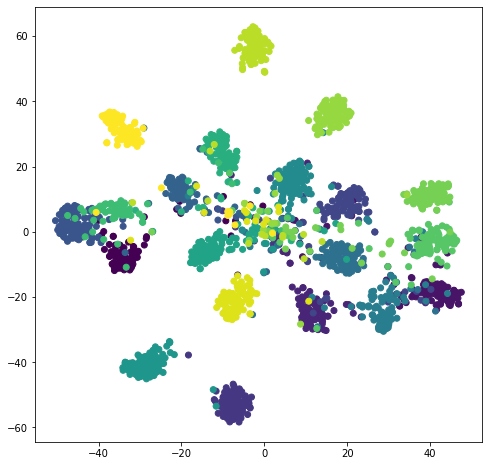

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

x_tsne = TSNE(n_components=2, random_state=42).fit_transform(list(x_test['tfidf']))

plt.rcParams['figure.figsize'] = [8, 8]
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=list(x_test['label']) )

--------------------------------------------------------------------------------
TSNE(n_jobs=2, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.09 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.7288, 50 iterations in 0.1209 sec
Iteration  100, KL divergence 2.7285, 50 iterations in 0.0507 sec
Iteration  150, KL divergence 2.7285, 50 iterations in 0.0464 sec
Iteration  200, KL divergence 2.7290, 50 iterations in 0.0443 sec
Iteration  250, KL divergence 2.7291, 50 iterations in 0.0433 sec
   --> Time elapsed: 0.31 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...

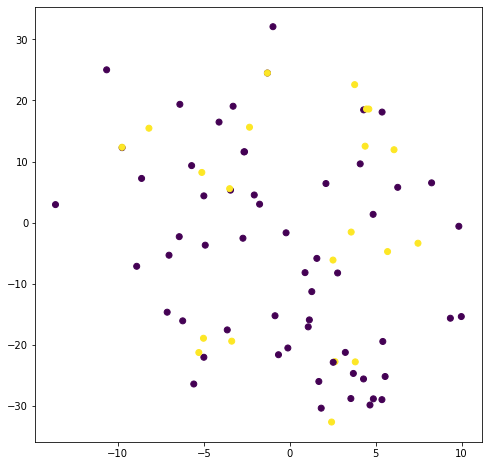

In [21]:
# plot tfidf bombado
from openTSNE import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=2,
    random_state=42,
    verbose=True,
)
embedding_train = tsne.fit(  numpy.array(list(x_train['tfidf'])) )
embedding_test = embedding_train.transform(numpy.array(list(x_test['tfidf'])))
plt.rcParams['figure.figsize'] = [8, 8]
print(f'tfidf bombado: {dataset}')
plt.scatter(embedding_test[:,0], embedding_test[:,1], c=list(x_test['label']) )

--------------------------------------------------------------------------------
TSNE(n_jobs=2, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.04 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...


/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


   --> Time elapsed: 0.16 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.6535, 50 iterations in 0.1053 sec
Iteration  100, KL divergence 2.6302, 50 iterations in 0.0595 sec
Iteration  150, KL divergence 2.6408, 50 iterations in 0.0616 sec
Iteration  200, KL divergence 2.6082, 50 iterations in 0.0679 sec
Iteration  250, KL divergence 2.6033, 50 iterations in 0.0608 sec
   --> Time elapsed: 0.36 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...
Iteration   50, KL divergence 1.9929, 50 iterations in 0.0527 sec
Iteration  100, KL divergence 1.8899, 50 iterations in 0.0469 sec
Iteration  150, KL divergence 1.8505, 50 iterations in 0.0469 sec
Iteration  200, KL divergence 1.8337, 50 iterations in 0.0480 sec
Iteration  250, KL divergence 1.8265, 50 iterations in 0.0466 sec
Iteration  300, KL divergence 1.8213, 50 iterations in 0.0466 sec
Iteration  350, KL divergence 1.8189, 50 

/home/claudiovaliense/projetos/combinacao_atencao/virtualenv/lib/python3.8/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


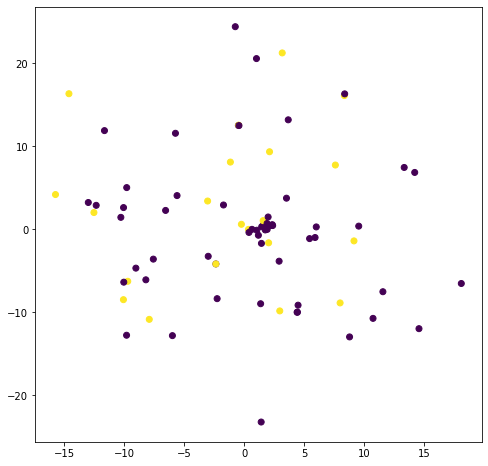

In [22]:
# tsne tfidf
x_train_tfidf, y_train, x_val_tfidf, y_val, x_test_tfidf, y_test = load_svmlight_files([open(f'kaggle_tfidf/{dataset}_tfidf_train{index_fold}', 'rb'),
    open(f'kaggle_tfidf/{dataset}_tfidf_val{index_fold}', 'rb'), open(f'kaggle_tfidf/{dataset}_tfidf_test{index_fold}', 'rb')])

from openTSNE import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=2,
    random_state=42,
    verbose=True,
)
embedding_train = tsne.fit(  x_train_tfidf.todense() )
embedding_test = embedding_train.transform( x_test_tfidf.todense() )
plt.rcParams['figure.figsize'] = [8, 8]
print(f'tfidf: {dataset}')
plt.scatter(embedding_test[:,0], embedding_test[:,1], c=y_test )